In [1]:
# note: This preprocessing and clustering basically follows the guideline in this website:
# https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html
# code by Ying Hu (huying@stanford.edu)

# unnote this if you don't have them installed
# ! pip install scrublet
# ! pip install harmonypy
# ! pip install rpy2

# Initialization

In [2]:
# Initialization - import libraries
import scanpy as sc
import pandas as pd
import scipy.io
import scipy.sparse
import gzip
import scrublet as scr
import seaborn as sns
import harmonypy as hm
import numpy as np
import scanpy.external as sce

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
# load individual octo_brain samples
octo_brain5 = "/Users/huying/Documents/Science/Rotation/Quake_Lab/data/rawdata/Oct5_brain_sc/filtered_feature_bc_matrix"
octo_brain6 = "/Users/huying/Documents/Science/Rotation/Quake_Lab/data/rawdata/Oct6_brain_sc/filtered_feature_bc_matrix"
octo_brain7 = "/Users/huying/Documents/Science/Rotation/Quake_Lab/data/rawdata/Oct7_brain_sc/filtered_feature_bc_matrix" 

output_path = "/Users/huying/Documents/Science/Rotation/Quake_Lab/data/rawdata/"

In [4]:
# convert raw format into .h5ad file
def load_mtx_data(data_path, output_file):
    """
    Load 10x Genomics formatted mRNA expression data and save as an AnnData object.

    Parameters:
    - data_path (str): Path to the directory containing `matrix.mtx.gz`, `barcodes.tsv.gz`, and `features.tsv.gz`.
    - output_file (str): Path to save the `.h5ad` file.

    Returns:
    - AnnData object containing the gene expression matrix.
    """
    # Read the matrix file (mRNA expression counts)
    with gzip.open(f"{data_path}/matrix.mtx.gz", "rt") as f:
        X = scipy.io.mmread(f)  # Read the MTX file
    X = scipy.sparse.csr_matrix(X)  # Convert to Compressed Sparse Row format

    # Read the barcodes (cell names)
    with gzip.open(f"{data_path}/barcodes.tsv.gz", "rt") as f:
        barcodes = pd.read_csv(f, header=None, sep="\t")[0].tolist()

    # Read the features (gene names)
    with gzip.open(f"{data_path}/features.tsv.gz", "rt") as f:
        features = pd.read_csv(f, header=None, sep="\t")

    # Extract gene names (column 2) and IDs (column 1)
    gene_ids = features[0].tolist()  # Gene IDs
    gene_names = features[1].tolist()  # Gene names (if available)

    # Create an AnnData object
    adata = sc.AnnData(X.T)

    # Assign cell barcodes and gene names
    adata.obs_names = barcodes
    adata.var_names = gene_names
    adata.var["gene_ids"] = gene_ids  # Store gene IDs separately

    # Save to an .h5ad file
    adata.write(output_file)

    return adata

octo_brain5 = load_mtx_data(octo_brain5, output_path + 'octo_brain_5.h5ad')
octo_brain6 = load_mtx_data(octo_brain6, output_path + 'octo_brain_6.h5ad')
octo_brain7 = load_mtx_data(octo_brain7, output_path + 'octo_brain_7.h5ad')

In [5]:
# merge .h5ad files of different samples

# add sample sources into obs
octo_brain5.obs["Sample"] = "octo.brain5"
octo_brain6.obs["Sample"] = "octo.brain6"
octo_brain7.obs["Sample"] = "octo.brain7"

# Rename cell names (obs_names) to include sample info
octo_brain5.obs_names = [f"octo.brain5_{cell}" for cell in octo_brain5.obs_names]
octo_brain6.obs_names = [f"octo.brain6_{cell}" for cell in octo_brain6.obs_names]
octo_brain7.obs_names = [f"octo.brain7_{cell}" for cell in octo_brain7.obs_names]

# merge different samples and save
octo_brain_merged = octo_brain5.concatenate(octo_brain6, octo_brain7, join="outer", batch_key=None)
octo_brain_merged.write(output_path + 'octo_brain_merged.h5ad')

print(octo_brain_merged)

/var/folders/tc/p82g1tcx5nl2m2dk32vzgnm00000gn/T/ipykernel_3182/3334138751.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  octo_brain_merged = octo_brain5.concatenate(octo_brain6, octo_brain7, join="outer", batch_key=None)


AnnData object with n_obs × n_vars = 66878 × 33609
    obs: 'Sample'
    var: 'gene_ids'


# Preprocessing and Clustering

<Font color = orange>

Note: For the octo_brain_merged.h5ad dataset, I performed DecontX analysis in R, a widely used tool in scRNA-seq data analysis for mitigating ambient RNA contamination. DecontX is not available in Python, but it is a crucial step for improving data quality. The original publication detailing this method can be found here: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1950-6.

I also attached the R file in the Github.

In [6]:
# load the file
octo_brain = sc.read_h5ad(output_path + 'octo_brain_decontxed.h5ad')

In [7]:
# Basic Quality Control Metrics

sc.pp.calculate_qc_metrics(octo_brain, percent_top=[50, 100], log1p=False, inplace=True) # compute QC values
octo_brain.obs.rename(columns={"total_counts": "nCount_RNA", "n_genes_by_counts": "nFeature_RNA"}, inplace=True) # rename for convenience

# Run Scrublet for doublet detection
scrub = scr.Scrublet(octo_brain.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

octo_brain.obs["doublet_score"] = doublet_scores
octo_brain.obs["predicted_doublet"] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 87.2 seconds


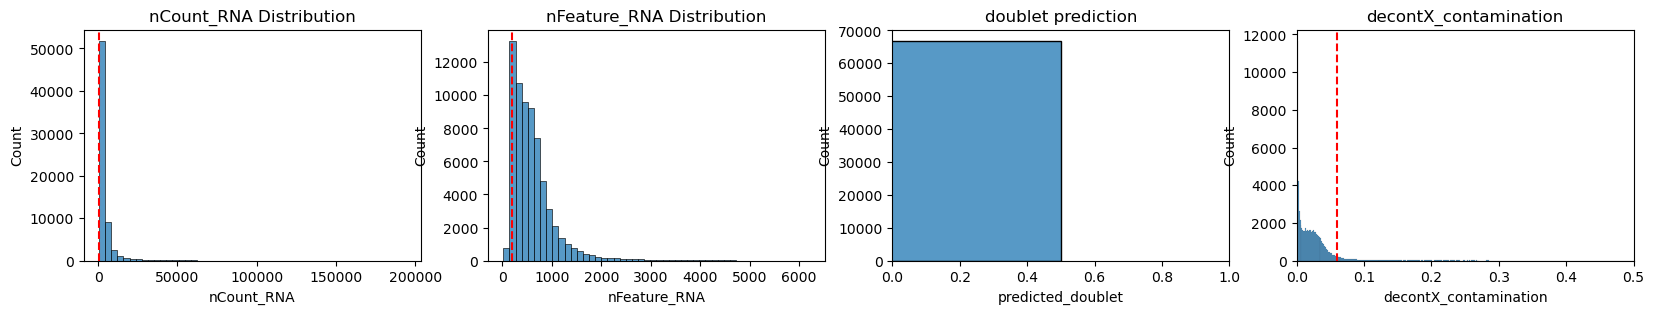

In [8]:
# plot quality control values

fig, axes = plt.subplots(1, 4, figsize=(20, 3))

sns.histplot(octo_brain.obs["nCount_RNA"], bins=50, ax=axes[0])
axes[0].axvline(400, color='r', linestyle='--')
axes[0].set_title("nCount_RNA Distribution")

sns.histplot(octo_brain.obs["nFeature_RNA"], bins=50, ax=axes[1])
axes[1].axvline(200, color='r', linestyle='--') 
axes[1].set_title("nFeature_RNA Distribution")

sns.histplot(octo_brain.obs["predicted_doublet"], ax=axes[2])
axes[2].set_title("doublet prediction")
axes[2].set_xlim(0,1)

sns.histplot(octo_brain.obs["decontX_contamination"], ax=axes[3])
axes[3].set_title("decontX_contamination")
axes[3].axvline(0.06, color='r', linestyle='--')
axes[3].set_xlim(0,0.5)

plt.show()

In [9]:
# Define thresholds and filtering
nCount_RNA_threshold = 400    
nFeature_RNA_threshold = 200 
doublet_threshold = 0.5
decontX_contamination = 0.06

octo_brain = octo_brain[
    (octo_brain.obs["predicted_doublet"] < doublet_threshold) &
    (octo_brain.obs["decontX_contamination"] < decontX_contamination) &
    (octo_brain.obs["nFeature_RNA"] > nFeature_RNA_threshold) &
    (octo_brain.obs["nCount_RNA"] > nCount_RNA_threshold), :
]

print(f"Filtered cell count: {octo_brain.n_obs}")

Filtered cell count: 57042


In [10]:
# Store raw counts before normalization
octo_brain.raw = octo_brain 

# perform normalization & log transformation
octo_brain.layers["counts"] = octo_brain.X.copy()
sc.pp.normalize_total(octo_brain)
sc.pp.log1p(octo_brain)


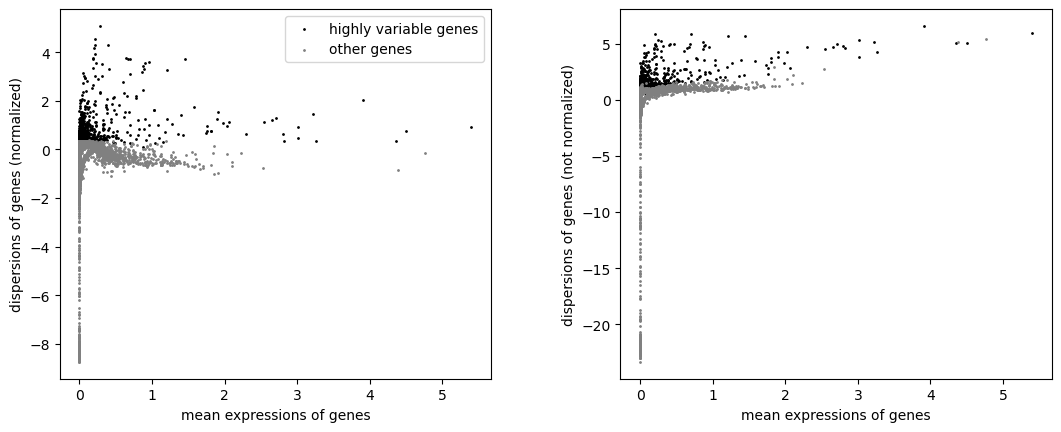

In [11]:
# Feature selection (top 2000)
sc.pp.highly_variable_genes(octo_brain, n_top_genes=2000, batch_key="Sample")
sc.pl.highly_variable_genes(octo_brain)

octo_brain = octo_brain[:, octo_brain.var.highly_variable]

/opt/anaconda3/envs/BIO265/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


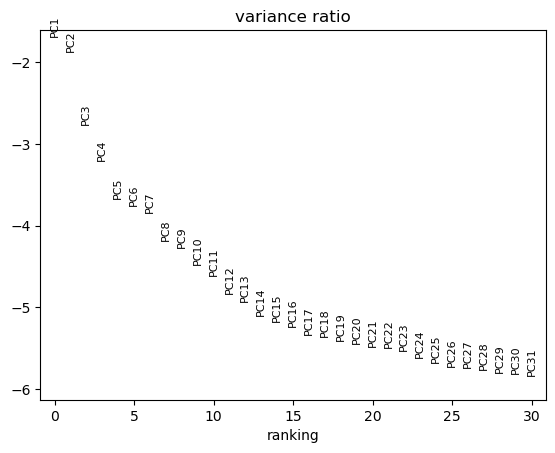

In [12]:
sc.pp.pca(octo_brain) # dimension reduction using PCA
sc.pl.pca_variance_ratio(octo_brain, n_pcs=30, log=True) # check PC contribution, I tried different n_pcs and choose n_pcs = 30

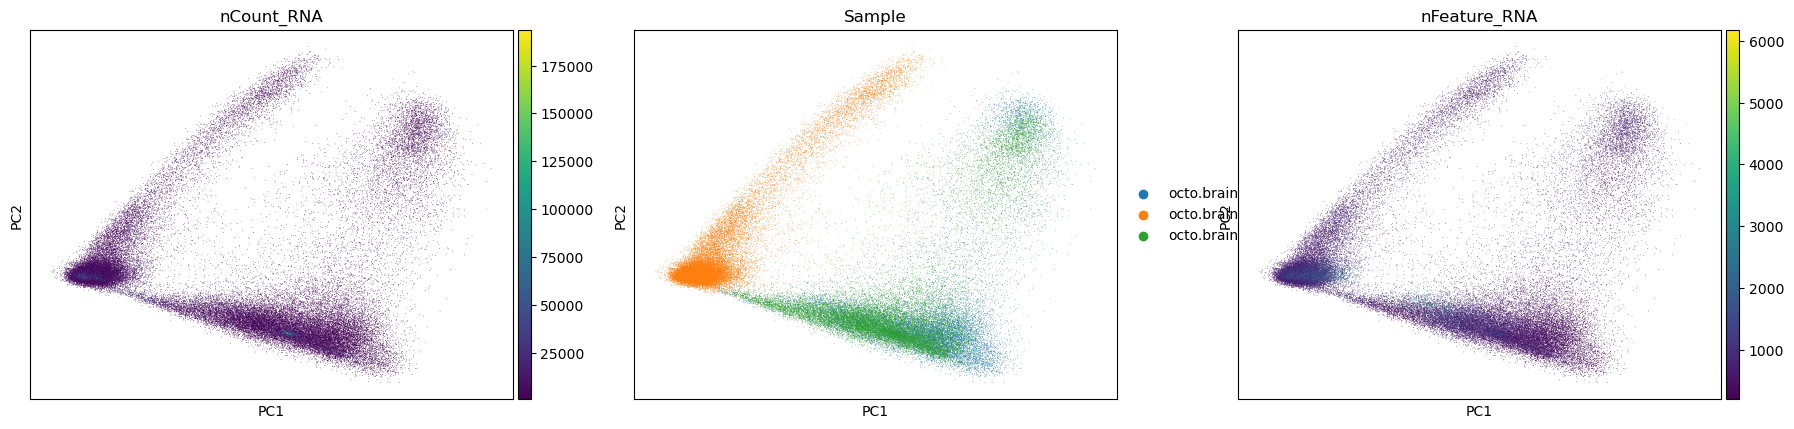

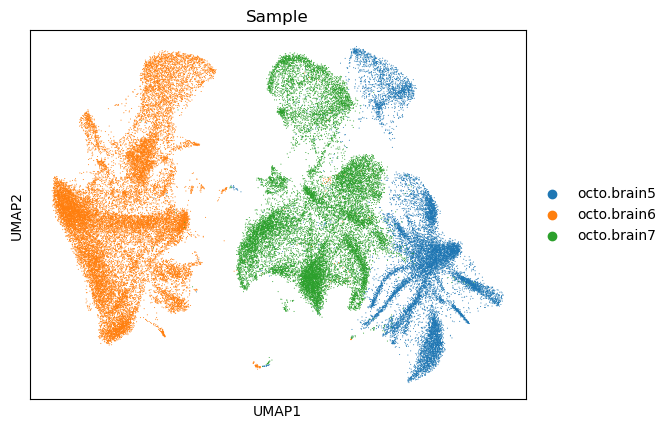

In [13]:
# plot the principal components to see if there are any potentially undesired features (e.g. batch, QC metrics) driving signifigant variation
sc.pl.pca(
    octo_brain,
    color=["nCount_RNA", "Sample", "nFeature_RNA"],
    dimensions=[(0, 1), (0, 1), (0, 1)],
    ncols=3,
    size=1,
)
sc.pp.neighbors(octo_brain)
sc.tl.umap(octo_brain)
sc.pl.umap(octo_brain, color=["Sample"])

# Nearest neighbor graph constuction and visualization

2025-03-11 22:00:13,177 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-11 22:00:16,182 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-11 22:00:16,294 - harmonypy - INFO - Iteration 1 of 10
2025-03-11 22:00:23,345 - harmonypy - INFO - Iteration 2 of 10
2025-03-11 22:00:29,964 - harmonypy - INFO - Iteration 3 of 10
2025-03-11 22:00:36,218 - harmonypy - INFO - Converged after 3 iterations


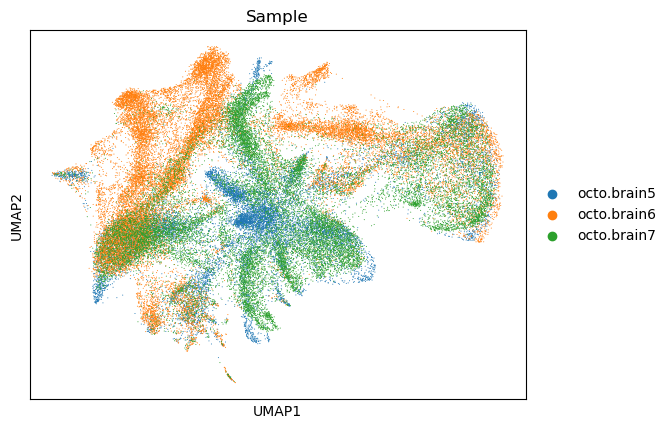

In [14]:
# Batch effect correction using ComBat
sce.pp.harmony_integrate(octo_brain, key="Sample")
sc.pp.pca(octo_brain)  
sc.pp.neighbors(octo_brain, use_rep="X_pca_harmony")  
sc.tl.umap(octo_brain)
sc.pl.umap(octo_brain, color=["Sample"])

# Clustering

In [15]:
# Define different resolutions for clustering to find the best one
resolutions = [0.2, 0.3, 0.5, 0.7, 0.8, 1.0]

for res in resolutions:
    key = f"leiden_{res}"  # Create a unique column name for each resolution
    sc.tl.leiden(octo_brain, resolution=res, key_added=key)

/var/folders/tc/p82g1tcx5nl2m2dk32vzgnm00000gn/T/ipykernel_3182/3211200807.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(octo_brain, resolution=res, key_added=key)


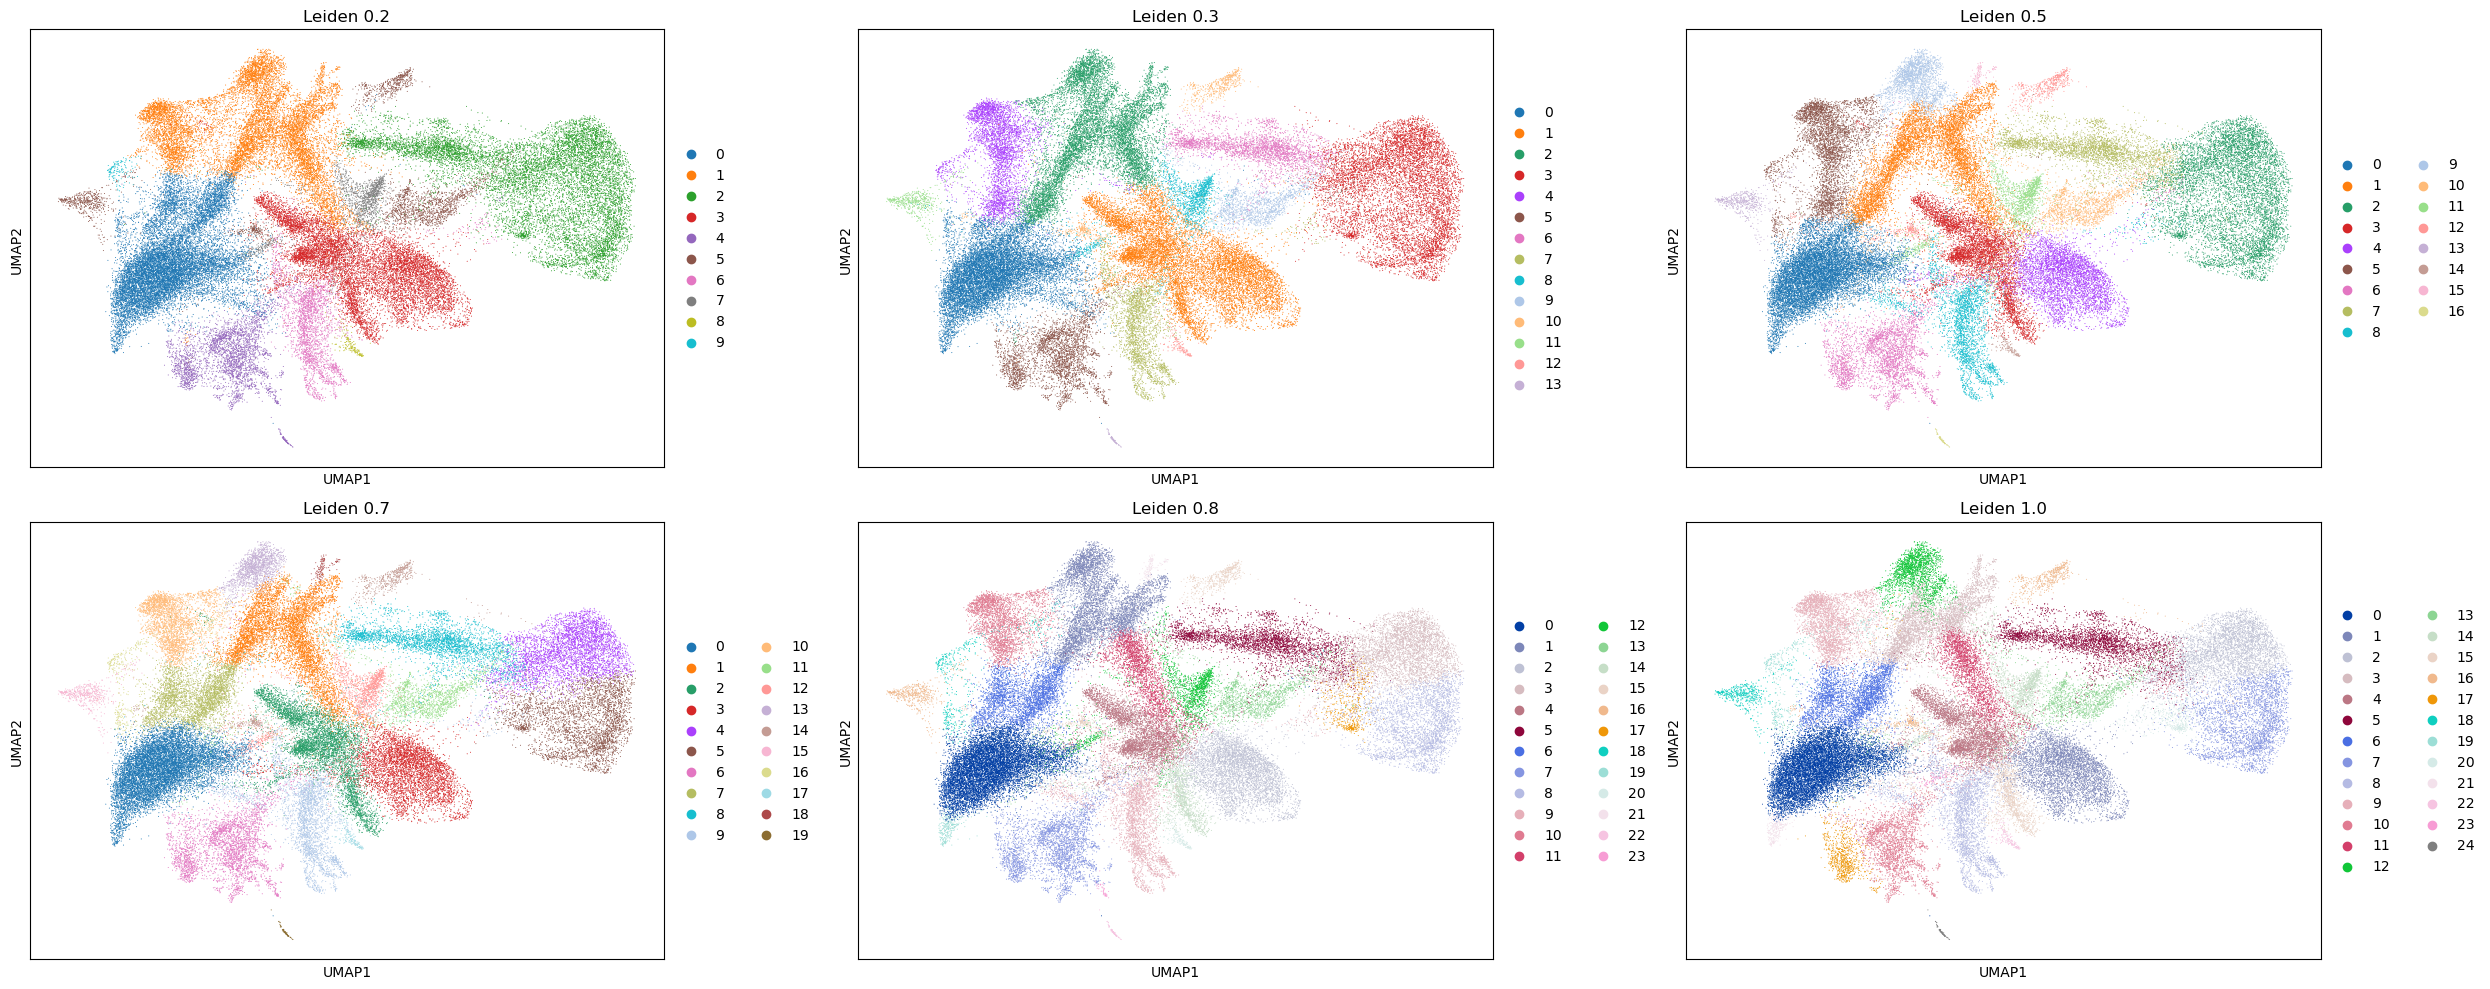

In [16]:
# plot the cluster results

# Compute the number of rows and columns
n_cols = 3  # Set 3 columns per row
n_rows = -(-len(resolutions) // n_cols)  # Compute the number of rows needed (ceil division)

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 10))  # Increased height for clarity
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot UMAPs for different resolutions
for i, res in enumerate(resolutions):
    key = f"leiden_{res}"
    sc.pl.umap(octo_brain, color=key, ax=axes[i], show=False, title=f"Leiden {res}")

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust spacing to avoid overlap
plt.show()

In [17]:
# define the best resolution
best_resolution = 0.7  # Choose based on visualization
octo_brain.obs["leiden"] = octo_brain.obs[f"leiden_{best_resolution}"]

In [19]:
octo_brain

AnnData object with n_obs × n_vars = 57042 × 2000
    obs: 'Sample', 'decontX_contamination', 'nFeature_RNA', 'nCount_RNA', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'doublet_score', 'predicted_doublet', 'leiden_0.2', 'leiden_0.3', 'leiden_0.5', 'leiden_0.7', 'leiden_0.8', 'leiden_1.0', 'leiden'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'X_name', 'log1p', 'hvg', 'pca', 'Sample_colors', 'neighbors', 'umap', 'leiden_0.2', 'leiden_0.3', 'leiden_0.5', 'leiden_0.7', 'leiden_0.8', 'leiden_1.0', 'leiden_0.2_colors', 'leiden_0.3_colors', 'leiden_0.5_colors', 'leiden_0.7_colors', 'leiden_0.8_colors', 'leiden_1.0_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [20]:
# Remove redundant variables
obs_to_remove = ["leiden_0.2", "leiden_0.3", "leiden_0.5", "leiden_0.7", "leiden_1.0", "leiden_0.8"]
octo_brain.obs.drop(columns=obs_to_remove, inplace=True)

var_to_keep = ["gene_ids", "highly_variable"]
octo_brain.var = octo_brain.var[var_to_keep]

uns_to_remove = [k for k in octo_brain.uns.keys() if "leiden" in k]  # Remove leiden-related entries
for k in uns_to_remove:
    del octo_brain.uns[k]

# Remove extra layers (if not needed)
if "counts" in octo_brain.layers:
    del octo_brain.layers["counts"]

# Save the cleaned AnnData object
octo_brain.write('/Users/huying/Documents/Science/Rotation/Quake_Lab/data/rawdata/octo_brain_preprocessed.h5ad')
print(octo_brain)


AnnData object with n_obs × n_vars = 57042 × 2000
    obs: 'Sample', 'decontX_contamination', 'nFeature_RNA', 'nCount_RNA', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_ids', 'highly_variable'
    uns: 'X_name', 'log1p', 'hvg', 'pca', 'Sample_colors', 'neighbors', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
